# Two storey steel moment frame with W-sections for displacement-controlled sensitivity analysis

This document will teach you how to use opstool to post-process sensitivity analysis.

The source code is developed by [Marin Grubišić at University of Osijek, Croatia](https://openseespydoc.readthedocs.io/en/latest/src/SteelFrameSensitivity2D_v1.html).

The numerical model with the associated analysis was described in detail by Prof. Michael Scott in the [Portwood Digital blog](https://portwooddigital.com/2021/01/03/sensitivity-training/).

![image.png](https://s2.loli.net/2025/03/30/svpNVRy7hEgTIoj.png)

In [1]:
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import opstool as opst

## OpenSees Model

Use the unit system provided by opstool:

In [2]:
length_unit = "inch"
force_unit = "kip"
UNIT = opst.pre.UnitSystem(length=length_unit, force=force_unit, time="sec")

### Define model  

In [3]:
# Create ModelBuilder
# -------------------
ops.wipe()
ops.model("basic", "-ndm", 2, "-ndf", 3)

# Create nodes
# ------------
ops.node(1, 0.0, 0.0)  # Ground Level
ops.node(2, 30 * UNIT.ft, 0.0)
ops.node(3, 0.0, 15 * UNIT.ft)  # 1st Floor Level
ops.node(4, 30 * UNIT.ft, 15 * UNIT.ft)
ops.node(5, 0.0, 2 * 15 * UNIT.ft)  # 2nd Floor Level
ops.node(6, 30 * UNIT.ft, 2 * 15 * UNIT.ft)

# Fix supports at base of columns
# -------------------------------
ops.fix(1, 1, 1, 1)
ops.fix(2, 1, 1, 1)

# Define material
# ---------------
matTag = 1
Fy = 50.0 * UNIT.ksi  # Yield stress
Es = 29000.0 * UNIT.ksi  # Modulus of Elasticity of Steel
b = 1 / 100  # 1% Strain hardening ratio

# Sensitivity-ready steel materials: Hardening, Steel01, SteelMP, BoucWen, SteelBRB, StainlessECThermal, SteelECThermal, ...
ops.uniaxialMaterial("Steel01", matTag, Fy, Es, b)
# ops.uniaxialMaterial("SteelMP", matTag, Fy, Es, b)

# Define sections
# ---------------
# Sections defined with "canned" section ("WFSection2d"), otherwise use a FiberSection object (ops.section("Fiber",...))
colSecTag, beamSecTag = 1, 2
WSection = {
    "W18x76": [
        18.2 * UNIT.inch,
        0.425 * UNIT.inch,
        11.04 * UNIT.inch,
        0.68 * UNIT.inch,
    ],  # [d, tw, bf, tf]
    "W14X90": [
        14.02 * UNIT.inch,
        0.44 * UNIT.inch,
        14.52 * UNIT.inch,
        0.71 * UNIT.inch,
    ],  # [d, tw, bf, tf]
}

#                          secTag,    matTag, [d, tw, bf, tf],    Nfw, Nff
ops.section("WFSection2d", colSecTag, matTag, *WSection["W14X90"], 20, 4)  # Column section
ops.section("WFSection2d", beamSecTag, matTag, *WSection["W18x76"], 20, 4)  # Beam section

# Define elements
# ---------------
colTransTag, beamTransTag = 1, 2
# Linear, PDelta, Corotational
ops.geomTransf("Corotational", colTransTag)
ops.geomTransf("Linear", beamTransTag)

colIntTag, beamIntTag = 1, 2
nip = 5
# Lobatto, Legendre, NewtonCotes, Radau, Trapezoidal, CompositeSimpson
(ops.beamIntegration("Lobatto", colIntTag, colSecTag, nip),)
ops.beamIntegration("Lobatto", beamIntTag, beamSecTag, nip)

# Column elements
ops.element("forceBeamColumn", 10, 1, 3, colTransTag, colIntTag, "-mass", 0.0)
ops.element("forceBeamColumn", 11, 3, 5, colTransTag, colIntTag, "-mass", 0.0)
ops.element("forceBeamColumn", 12, 2, 4, colTransTag, colIntTag, "-mass", 0.0)
ops.element("forceBeamColumn", 13, 4, 6, colTransTag, colIntTag, "-mass", 0.0)

# Beam elements
ops.element("forceBeamColumn", 14, 3, 4, beamTransTag, beamIntTag, "-mass", 0.0)
ops.element("forceBeamColumn", 15, 5, 6, beamTransTag, beamIntTag, "-mass", 0.0)

# Create a Plain load pattern with a Linear TimeSeries
# ----------------------------------------------------
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)

### Define Sensitivity Parameters 

In [4]:
# /// Each parameter must be unique in the FE domain, and all parameter tags MUST be numbered sequentially starting from 1! ///
ops.parameter(1)  # Blank parameters
ops.parameter(2)
ops.parameter(3)
for ele in [10, 11, 12, 13]:  # Only column elements
    ops.addToParameter(1, "element", ele, "E")  # "E"
    # Check the sensitivity parameter name in *.cpp files ("sigmaY" or "fy", somewhere also "Fy")
    # https://github.com/OpenSees/OpenSees/blob/master/SRC/material/uniaxial/Steel02.cpp
    ops.addToParameter(2, "element", ele, "fy")  # "sigmaY" or "fy" or "Fy"
    ops.addToParameter(3, "element", ele, "b")  # "b"

ParamSym = {1: "E", 2: "F_y", 3: "b"}
ParamVars = {1: Es, 2: Fy, 3: b}

### Run gravity analysis (in 10 steps)

In [5]:
steps = 10

ops.wipeAnalysis()
ops.system("BandGeneral")
ops.numberer("RCM")
ops.constraints("Transformation")
ops.test("NormDispIncr", 1.0e-12, 10, 3)
ops.algorithm("Newton")  # KrylovNewton
ops.integrator("LoadControl", 1 / steps)
ops.analysis("Static")
ops.analyze(steps)
# Set the gravity loads to be constant & reset the time in the domain
ops.loadConst("-time", 0.0)
ops.wipeAnalysis()

### Run sensitivity and pushover analysis

#### Define nodal loads for pushover analysis

In [6]:
ops.pattern("Plain", 2, 1)  # new load pattern 2
# Create nodal loads at nodes 3 & 5
#       nd  FX   FY   MZ
ops.load(3, 1 / 3, 0.0, 0.0)
ops.load(5, 2 / 3, 0.0, 0.0)
P = 1 / 3 + 2 / 3  # Total load

#### Control node and dof for pushover analysis

In [7]:
ctrlNode = 5
dof = 1
Dincr = (1 / 25) * UNIT.inch
max_disp = 20 * UNIT.inch

#### Setting up the analysis algorithm

In [8]:
ops.wipeAnalysis()
ops.system("BandGeneral")
ops.constraints("Transformation")
ops.numberer("RCM")
ops.test("NormDispIncr", 1.0e-8, 10)
ops.algorithm("Newton")
# Change the integration scheme to be displacement control
#                                     node      dof  init Jd min max
ops.integrator("DisplacementControl", ctrlNode, dof, Dincr)
ops.analysis("Static")
ops.sensitivityAlgorithm("-computeAtEachStep")  # automatically compute sensitivity at the end of each step

#### Run the analysis

Here we use the [smart analysis algorithm](https://opstool.readthedocs.io/en/latest/src/api/_autosummary/opstool.anlys.SmartAnalyze.html#opstool.anlys.SmartAnalyze) provided by opstool, which can help convergence. 

It should be noted that since the **integrator may be reset internally**, you need to call the ``set_sensitivity_algorithm`` method to inform you that you are running sensitivity analysis so that the sensitivity analysis algorithm is reset every time the integrator is reset.

In [9]:
analysis = opst.anlys.SmartAnalyze(
    analysis_type="Static",
    tryAlterAlgoTypes=True,
    algoTypes=[40, 10],
    printPer=100,
)
analysis.set_sensitivity_algorithm("-computeAtEachStep")
segs = analysis.static_split([max_disp], Dincr)
ODB = opst.post.CreateODB("sensitivity-pushover", save_sensitivity_resp=True)
for seg in segs:
    analysis.StaticAnalyze(node=ctrlNode, dof=dof, seg=seg)
    # ops.analyze(1)
    ODB.fetch_response_step()
ODB.save_response()


Output()

>>> SmartAnalyze: Successfully finished! Time consumption: 4.794 s.

OPSTOOL ::  All responses data with _odb_tag = sensitivity-pushover saved in 
_OPSTOOL_ODB/RespStepData-sensitivity-pushover.nc!

![image22.png](https://s2.loli.net/2025/04/19/EsjSAZlFpwYDe4L.png)

## Post-processing

In [10]:
ctrlNode = 5  # Node 5
dof = "UX"  # 1st DOF (X direction)

### Loading node response

In [11]:
node_resp = opst.post.get_nodal_responses(odb_tag="sensitivity-pushover")
print("data variables:", node_resp.data_vars)
print("-" * 100)
print("dimensions:", node_resp.dims)
print("-" * 100)
print("coordinates:", node_resp.coords)

OPSTOOL ::  Loading all response data from _OPSTOOL_ODB/RespStepData-sensitivity-pushover.nc ...

data variables: Data variables:
    disp                (time, nodeTags, DOFs) float64 144kB 0.0 ... -0.02203
    vel                 (time, nodeTags, DOFs) float64 144kB 0.0 0.0 ... 0.0 0.0
    accel               (time, nodeTags, DOFs) float64 144kB 0.0 0.0 ... 0.0 0.0
    reaction            (time, nodeTags, DOFs) float64 144kB 0.0 ... -2.728e-11
    reactionIncInertia  (time, nodeTags, DOFs) float64 144kB 0.0 ... -2.728e-11
    rayleighForces      (time, nodeTags, DOFs) float64 144kB 0.0 0.0 ... 0.0 0.0
    pressure            (time, nodeTags) float64 24kB 0.0 0.0 0.0 ... 0.0 0.0
----------------------------------------------------------------------------------------------------
dimensions: FrozenMappingWarningOnValuesAccess({'time': 501, 'nodeTags': 6, 'DOFs': 6})
----------------------------------------------------------------------------------------------------
coordinates: Coordinates:
  * nodeTags  (nodeTags) int32 24B 1 2 3 4 5 6
  * DOFs      (DOFs) <U2 48B 'UX' 'UY' 'UZ' 'R

We use the ``.sel`` method to retrieve the displacement of node 5 on UX and total reaction force:

In [12]:
times = node_resp["time"].data
disp = node_resp["disp"].sel(nodeTags=ctrlNode, DOFs=dof)
force = -node_resp["reaction"].sel(DOFs=dof).sum(dim="nodeTags")

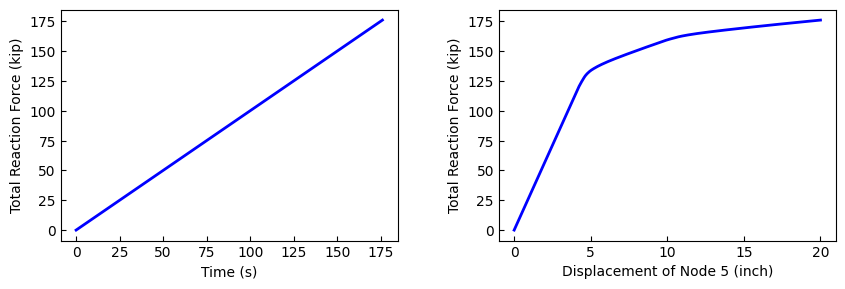

In [13]:
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(times, force, lw=2, color="blue")
axs[0].set_xlabel("Time (s)")
axs[1].plot(disp, force, lw=2, color="blue")
axs[1].set_xlabel(f"Displacement of Node {ctrlNode} ({length_unit})")
for ax in axs:
    ax.set_ylabel(f"Total Reaction Force ({force_unit})")
    # ax.grid()
plt.subplots_adjust(wspace=0.3)
plt.show()

### Loading the sensitivity response data

In [14]:
sens_resp = opst.post.get_sensitivity_responses(odb_tag="sensitivity-pushover")
print("data variables:", sens_resp.data_vars)
print("-" * 100)
print("dimensions:", sens_resp.dims)
print("-" * 100)
print("coordinates:", sens_resp.coords)

OPSTOOL ::  Loading response data from _OPSTOOL_ODB/RespStepData-sensitivity-pushover.nc ...

data variables: Data variables:
    disp      (time, paraTags, nodeTags, DOFs) float64 433kB 0.0 0.0 ... 0.4655
    vel       (time, paraTags, nodeTags, DOFs) float64 433kB 0.0 0.0 ... 0.0 0.0
    accel     (time, paraTags, nodeTags, DOFs) float64 433kB 0.0 0.0 ... 0.0 0.0
    pressure  (time, paraTags, nodeTags) float64 72kB 0.0 0.0 0.0 ... 0.0 0.0
    lambdas   (time, paraTags, patternTags) float64 24kB 0.0 0.0 ... 1.111e+03
----------------------------------------------------------------------------------------------------
dimensions: FrozenMappingWarningOnValuesAccess({'time': 501, 'paraTags': 3, 'nodeTags': 6, 'DOFs': 6, 'patternTags': 2})
----------------------------------------------------------------------------------------------------
coordinates: Coordinates:
  * paraTags     (paraTags) int32 12B 1 2 3
  * nodeTags     (nodeTags) int32 24B 1 2 3 4 5 6
  * DOFs         (DOFs) <U2 48B 'UX' 'UY' 'UZ' 'RX' 'RY' 'RZ'
  * patternTags  (patternTags) int32 8B 1 2
  * time         (ti

Get all parameter tags:

In [15]:
paraTags = sens_resp.paraTags.data
print("parameter tags:", paraTags)

parameter tags: [1 2 3]


### Sensitivity of load multipliers to various parameters

Retrieve the sensitivity of the load multiplier to various parameters in load pattern 2:

In [16]:
sens_lambda = sens_resp["lambdas"].sel(patternTags=2)
print(sens_lambda)

<xarray.DataArray 'lambdas' (time: 501, paraTags: 3)> Size: 12kB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.97155608e-05, 0.00000000e+00, 3.64022053e-02],
       [3.94311746e-05, 0.00000000e+00, 7.28045084e-02],
       ...,
       [5.01929058e-04, 1.42276659e+00, 1.10596076e+03],
       [5.02876040e-04, 1.42277552e+00, 1.10856418e+03],
       [5.03823047e-04, 1.42278447e+00, 1.11116767e+03]])
Coordinates:
  * paraTags     (paraTags) int32 12B 1 2 3
    patternTags  int32 4B 2
  * time         (time) float64 4kB 0.0 1.138 2.277 3.415 ... 175.9 176.0 176.0


### Plotting

The left column shows the sensitivity of load multiplier $\lambda$ to each parameter $P$ and the product of the parameter value:
$$ \left( \partial \lambda/\partial {P} \right){P} $$

The right column shows the hysteresis diagram of displacement $U$ and total reaction force $V_b$, where the $\lambda$ includes a sensitivity change of 1 times, i.e., $\left( \partial \lambda/\partial {P} \right){P}$

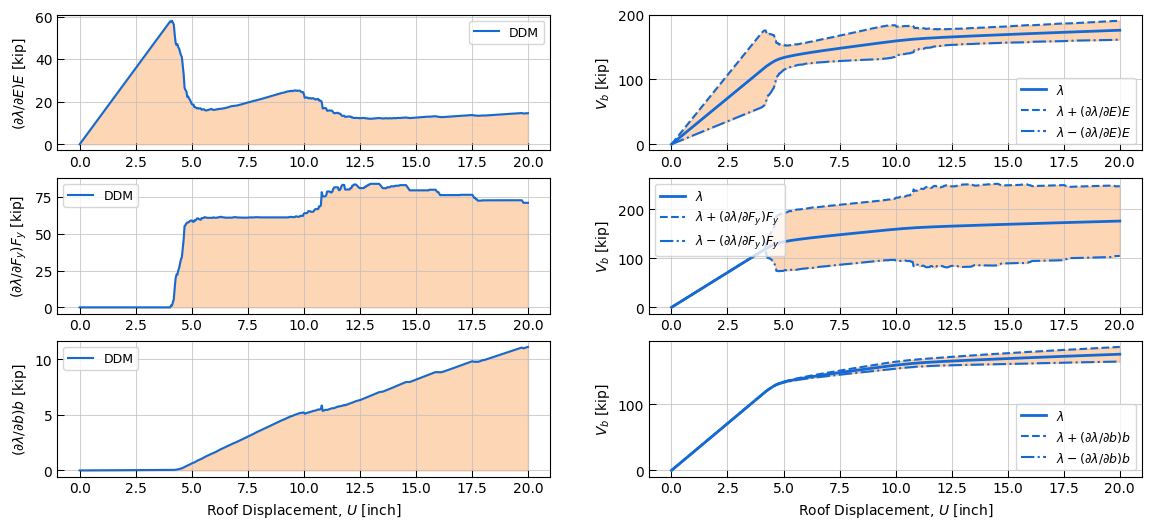

In [17]:
fig, axs = plt.subplots(len(paraTags), 2, figsize=(7 * 2, 2 * len(paraTags)))

for j, para_tag in enumerate(paraTags):
    para_value = ParamVars[para_tag]
    para_sym = ParamSym[para_tag]
    sens = sens_lambda.sel(paraTags=para_tag)
    # Subplot #i
    # ----------
    axs[j, 0].plot(disp, sens * para_value, c="#136ad5", linewidth=1.5, label="DDM")
    axs[j, 0].fill_between(disp, sens * para_value, 0.0, color="#fb8a2e", alpha=0.35)
    axs[j, 0].set_ylabel(f"$(\\partial \\lambda/\\partial {para_sym}){para_sym}$ [{force_unit}]")
    axs[j, 0].legend(fontsize=9)

    # Subplot #ii
    # -----------
    axs[j, 1].plot(disp, force, c="#136ad5", linewidth=2.0, label="$\\lambda$")
    axs[j, 1].plot(
        disp,
        force + sens * para_value,
        c="#136ad5",
        ls="--",
        linewidth=1.5,
        label=f"$\\lambda + (\\partial \\lambda/\\partial {para_sym}){para_sym}$",
    )
    axs[j, 1].plot(
        disp,
        force - sens * para_value,
        c="#136ad5",
        ls="-.",
        linewidth=1.5,
        label=f"$\\lambda - (\\partial \\lambda/\\partial {para_sym}){para_sym}$",
    )
    axs[j, 1].fill_between(
        disp,
        force + sens * para_value,
        force - sens * para_value,
        color="#fb8a2e",
        alpha=0.35,
    )

    axs[j, 1].set_ylabel(f"$V_b$ [{force_unit}]")
    axs[j, 1].legend(fontsize=9)

for ax in axs.flat:
    ax.tick_params(direction="in", length=5, colors="k", width=0.75)
    ax.grid(True, color="silver", linestyle="solid", linewidth=0.75, alpha=0.75)
    if j == 2:
        ax.set_xlabel(f"Roof Displacement, $U$ [{length_unit}]")
plt.subplots_adjust(wspace=0.2)
plt.show()